In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


(23708, 100, 100, 3) (23708,)
(23705, 100, 100, 3) (23705,)
(18964, 100, 100, 3) (18964,) (4741, 100, 100, 3) (4741,)
(15171, 100, 100, 3) (15171, 5) (3793, 100, 100, 3) (3793, 5)
Epoch 1/40
474/474 [==============================] - 123s 260ms/step - loss: 1.0238 - acc: 0.6311 - val_loss: 0.8590 - val_acc: 0.7039
Epoch 2/40
474/474 [==============================] - 113s 238ms/step - loss: 0.7670 - acc: 0.7330 - val_loss: 0.8289 - val_acc: 0.7408
Epoch 3/40
474/474 [==============================] - 113s 238ms/step - loss: 0.6940 - acc: 0.7598 - val_loss: 0.7879 - val_acc: 0.7495
Epoch 4/40
474/474 [==============================] - 113s 239ms/step - loss: 0.6292 - acc: 0.7834 - val_loss: 0.6403 - val_acc: 0.7849
Epoch 5/40
474/474 [==============================] - 112s 236ms/step - loss: 0.5862 - acc: 0.7923 - val_loss: 0.6950 - val_acc: 0.7825
Epoch 6/40
474/474 [==============================] - 112s 237ms/step - loss: 0.5581 - acc: 0.8085 - val_loss: 0.7251 - val_acc: 0.7762
Epoc

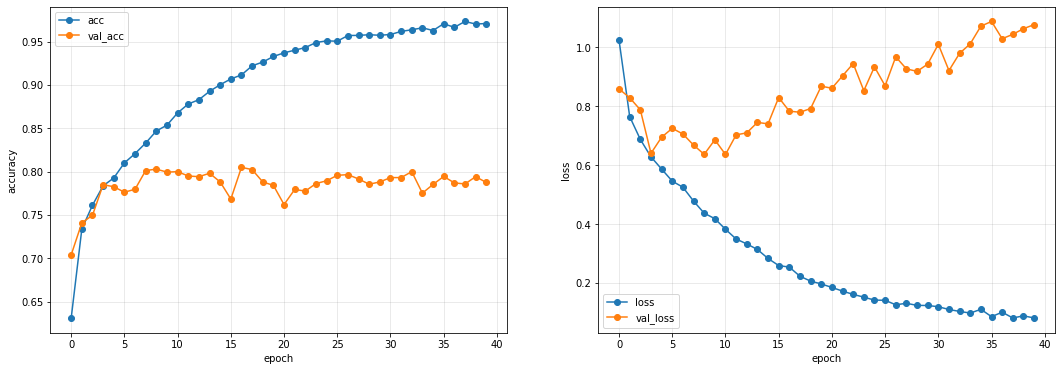

4741/4741 [==============================] - 13s 3ms/step
evaluate loss: 1.0544
evaluate acc: 79.1%


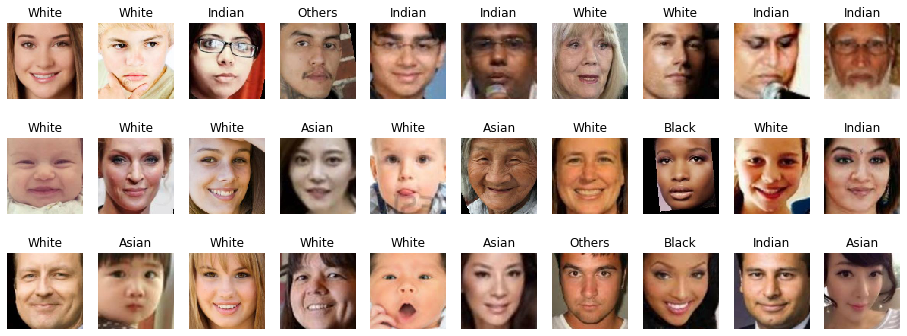

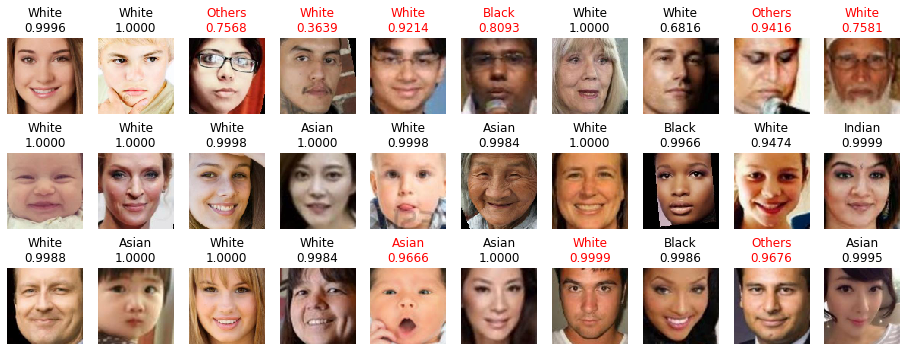

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, zipfile, io, re
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.applications.xception import Xception
from keras.models import Model, load_model
from keras.layers.core import Dense
from keras.layers.pooling import GlobalAveragePooling2D
from keras.optimizers import Adam, RMSprop, SGD
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator


#識別結果のlist
classes = ["White", "Black", "Asian", "Indian", "Others"]
num_classes = len(classes)
image_size = 100


# ZIP読み込み
z = zipfile.ZipFile('drive/My Drive/Advanced Laboratory of Intelligent System Technologies/32-op/week4/UTKFace.zip', 'r')
# 画像ファイルパスのみ取得
imgfiles = [ x for x in z.namelist() if re.search(r"^UTKFace.*jpg$", x)]

X = []
Y = []
for imgfile in imgfiles:
    # ZIPから画像読み込み
    image = Image.open(io.BytesIO(z.read(imgfile)))
    # RGB変換
    image = image.convert('RGB')
    # リサイズ
    image = image.resize((image_size, image_size))
    # 画像から配列に変換
    data = np.asarray(image)
    file = os.path.basename(imgfile)
    file_split = [i for i in file.split('_')]
    X.append(data)
    Y.append(file_split[2])
z.close()
del z, imgfiles

X = np.array(X)
Y = np.array(Y)
print(X.shape, Y.shape)


#人種がラベリングされていなかったのでデータを削除した．
index = np.where(
    (Y == "20170109142408075.jpg.chip.jpg") | 
    (Y == "20170109150557335.jpg.chip.jpg") | 
    (Y == "20170116174525125.jpg.chip.jpg")
)
X=np.delete(X, index, axis=0)
Y=np.delete(Y, index, axis=0)
print(X.shape, Y.shape)

# 学習データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(
    X, Y,
    random_state = 0,
    stratify = Y,
    test_size = 0.2
)
del X,Y
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# データ型の変換＆正規化
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
# one-hot変換
y_train = to_categorical(y_train, num_classes = num_classes)
y_test = to_categorical(y_test, num_classes = num_classes)

# 学習データから検証データを分割
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    random_state = 0,
    stratify = y_train,
    test_size = 0.2
)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape) 


#
#model構築していく
#
base_model = Xception(
    include_top = False,
    weights = "imagenet",
    input_shape = None
)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
predictions = Dense(num_classes, activation = 'softmax')(x)


datagen = ImageDataGenerator(
    featurewise_center = False,
    samplewise_center = False,
    featurewise_std_normalization = False,
    samplewise_std_normalization = False,
    zca_whitening = False,
    rotation_range = 0,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    vertical_flip = False
)

# log for TensorBoard
logging = TensorBoard(log_dir = "log/")

# ネットワーク定義
model = Model(inputs = base_model.input, outputs = predictions)

#108層までfreeze
for layer in model.layers[:108]:
    layer.trainable = False

    # Batch Normalizationのfreeze解除
    if layer.name.startswith('batch_normalization'):
        layer.trainable = True
    if layer.name.endswith('bn'):
        layer.trainable = True

#109層以降、学習させる
for layer in model.layers[108:]:
    layer.trainable = True

# layer.trainableの設定後にcompile
model.compile(
    optimizer = Adam(),
    loss = 'categorical_crossentropy',
    metrics = ["accuracy"]
)

hist = model.fit_generator(
    datagen.flow(X_train, y_train, batch_size = 32),
    steps_per_epoch = X_train.shape[0] // 32,
    epochs = 40,
    validation_data = (X_valid, y_valid),
    shuffle = True,
    verbose = 1
)


plt.figure(figsize = (18,6))

# accuracy
plt.subplot(1, 2, 1)
plt.plot(hist.history["acc"], label = "acc", marker = "o")
plt.plot(hist.history["val_acc"], label = "val_acc", marker = "o")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(loc = "best")
plt.grid(color = 'gray', alpha = 0.2)

# loss
plt.subplot(1, 2, 2)
plt.plot(hist.history["loss"], label = "loss", marker = "o")
plt.plot(hist.history["val_loss"], label = "val_loss", marker = "o")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(loc = "best")
plt.grid(color = 'gray', alpha = 0.2)

plt.show()


score = model.evaluate(X_test, y_test, verbose = 1)
print("evaluate loss: {[0]:.4f}".format(score))
print("evaluate acc: {[1]:.1%}".format(score))


model_dir = './model/'
if os.path.exists(model_dir) == False:os.mkdir(model_dir)

model.save(model_dir + 'model.hdf5')

# optimizerのない軽量モデルを保存（学習や評価は不可だが、予測は可能）
model.save(model_dir + 'model-opt.hdf5', include_optimizer = False)


# testデータ30件の正解ラベル
true_classes = np.argmax(y_test[0:30], axis = 1)

# testデータ30件の画像と正解ラベルを出力
plt.figure(figsize = (16, 6))
for i in range(30):
    plt.subplot(3, 10, i + 1)
    plt.axis("off")
    plt.title(classes[true_classes[i]])
    plt.imshow(X_test[i])
plt.show()

# testデータ30件の予測ラベル
pred_classes = np.argmax(model.predict(X_test[0:30]), axis = 1)

# testデータ30件の予測確率
pred_probs = np.max(model.predict(X_test[0:30]), axis = 1)
pred_probs = ['{:.4f}'.format(i) for i in pred_probs]

# testデータ30件の画像と予測ラベル・予測確率を出力
plt.figure(figsize = (16, 6))
for i in range(30):
    plt.subplot(3, 10, i + 1)
    plt.axis("off")
    if pred_classes[i] == true_classes[i]:
        plt.title(classes[pred_classes[i]]+'\n'+pred_probs[i])
    else:
        plt.title(classes[pred_classes[i]]+'\n'+pred_probs[i], color = "red")
    plt.imshow(X_test[i])
plt.show()